# Case study: electoral wards in Leeds

Getting hold of the wards in Leeds seems tricky, and requires joining two datasets and some HTTP work.  Makes it fun, I guess.

We start from data from Leeds city council.  But this only gives links to the shapefiles.

Wards in Leeds, (c) Leeds City Council, 2014, https://datamillnorth.org/dataset/wards-in-leeds.  This information is licensed under the terms of the Open Government Licence.

In [1]:
import csv, requests

url = "https://aql.datapress.com/leeds/dataset/wards-in-leeds/wardsgeoarea.csv"
response = requests.get(url)

In [2]:
import io

file = io.StringIO(response.content.decode("utf8"))

In [3]:
reader = csv.reader(file)
next(reader)

['Ward Code', 'Ward Name', 'Office for National Statistics URL']

In [4]:
import collections

Ward = collections.namedtuple("Ward", ["code", "name", "url"])
wards = [Ward(*row) for row in reader]
wards[0]    

Ward(code='E05001411', name='Adel and Wharfedale', url='http://statistics.data.gov.uk/id/statistical-geography/E05001411')

## Grab ONS data

We now need to follow each URL.  This data:

- Contains National Statistics data © Crown copyright and database right [year]
- Contains OS data © Crown copyright and database right [year]

See https://www.ons.gov.uk/methodology/geography/licences

In [8]:
import json

url = "http://statistics.data.gov.uk/boundaries/{}.json"
shapes = dict()
for ward in wards:
    response = requests.get(url.format(ward.code))
    shapes[ward.code] = json.loads(response.content.decode("utf8"))

## Load into geoPandas

In [10]:
import geopandas as gpd

In [14]:
frame = gpd.GeoDataFrame.from_features(shapes.values())
frame.head()

,LAD15CD,LAD15NM,WD15CD,WD15NM,WD15NMW,geometry,gml_id
0,E08000035,Leeds,E05001411,Adel and Wharfedale,None,(POLYGON ((-1.629940615700494 53.8472376637434...,ideaf6de43-8341-448b-b4c5-cc09961a2047
1,E08000035,Leeds,E05001412,Alwoodley,None,(POLYGON ((-1.500439866659665 53.8483119423158...,idb6c65d32-3ee5-459c-a97b-79055c672704
2,E08000035,Leeds,E05001413,Ardsley and Robin Hood,None,(POLYGON ((-1.582089878814699 53.7138678269042...,idcee7c42f-2e65-4450-a231-3ebe8fb6fa82
3,E08000035,Leeds,E05001414,Armley,None,(POLYGON ((-1.581497010092719 53.7905557884060...,id292849df-8946-468c-8bc5-37da925c7051
4,E08000035,Leeds,E05001415,Beeston and Holbeck,None,(POLYGON ((-1.586387043526911 53.7665368873094...,id40ee5f96-5539-4fde-908e-b6246dfa9cdb


## Plot

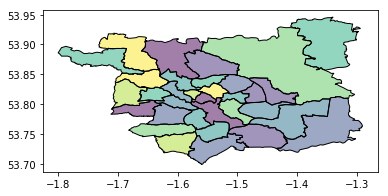

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

frame.plot()

In [17]:
# Set projection as lon/lat, then reproject to "web mercator"
frame.crs = {"init": "EPSG:4326"}
frame = frame.to_crs({"init": "EPSG:3857"})

In [19]:
import tilemapbase

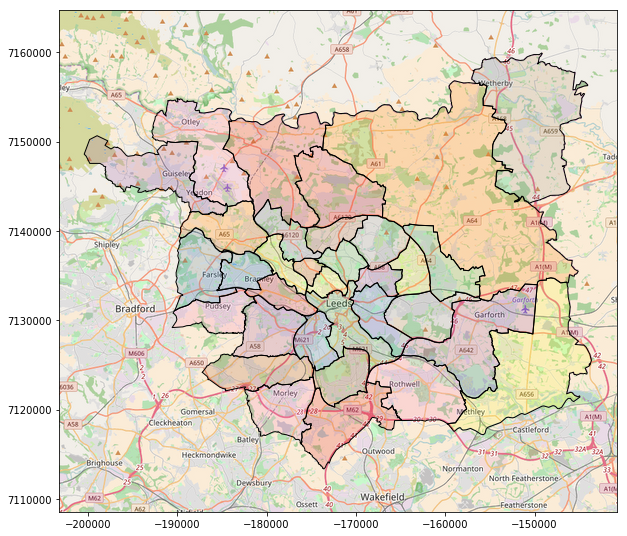

In [33]:
fig, ax = plt.subplots(figsize=(10,10))

extent = tilemapbase.extent_from_frame(frame, 1000, 5)
extent.plot(ax, tilemapbase.tiles.OSM)
frame.plot(ax=ax, column="WD15NM", categorical=True, alpha=0.2)
None

We could add a legend, but geoPandas isn't great at doing that (yet...)